In [1]:
from google.colab import files, drive
drive.mount('/content/drive')# follow the prompt to mount your Google Drive
! cp drive/MyDrive/Colab-Notebooks/Unsupervised-Learning/hw1_data.zip ./hw1.zip
# Note: you might need to change the above path if hw1.zip is in a different 
#   folder in your Google drive. As a hint, your Google drive root folder is 
#   /content/drive/ or ./drive 
! unzip hw1.zip 
! cp drive/MyDrive/TTIC31220-Winter21/hw3/*.py ./
! ln -s /content/drive/MyDrive/TTIC31220-Winter21/hw3/Wiki/ ./data/Wiki

Mounted at /content/drive
Archive:  hw1.zip
   creating: data/
  inflating: data/noisy_two_view_distribute.mat  
  inflating: data/idx.mat            
  inflating: data/noisy_distribute.mat  
  inflating: data/original_distribute.mat  
  inflating: dataset.py              
  inflating: plot.py                 
  inflating: svm.py                  
  inflating: utils.py                


In [2]:
%matplotlib inline
import utils
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist
from numpy.random import permutation as rpm
from plot import plot_images, plot_dendrogram, plot_confusion_matrix
from dataset import read_mnist, read_mnist_twoview
from utils import resize, sample_index, gen_solution, get_purity, get_nmi
from sklearn.decomposition import PCA

# **Formulation for k-mean:**

The input of the algorithm is the raw data, number of clusters, number of time the k-means algorithm will be run with different centroid seeds, and max iterations.

In K-mean, what we want to do is to minimize the "distortion measure" $J$, where

$$J=\sum_{n=1}^N\sum_{k=1}^Nr_{nk}||x_n-\mu_k||$$,

which represents the sum of the squares of the distances of each data point to its assigned vector. 

In order to minimize $J$, we have to find values for $r_{nk}$ and $\mu_k$. And we assign 

$$
r_{nk}=
\left\{  
             \begin{array}{**lr**}  
             1, \qquad k = argmin_j||x_n-\mu_j|| \\
             0, \qquad otherwise
             \end{array}  
\right. 
$$
So now by finding the derivative of $J$ with respect to $\mu_k$, we will have

$$2\sum_{n=1}^N r_{nk}(x_n-\mu_k)=0$$

and $\mu_k$ is given by $$\mu_k=\frac {\sum_n r_{nk}x_n} {\sum_n r_{nk}}$$



# **Formulation for hierarchical cluster:**

The input of the algorithm is the raw data, number of clusters, method to compute distances between clusters, and methods to compute distance matrix.

I will show the algorithm of hierarchical cluster using Ward's method.

1. Start with each point in a cluster by itself (sum of squares = 0).

2. Merge two clusters, in order to produce the smallest increase in the sum of squares (the smallest merging cost).

3. Keep merging until you’ve reached k clusters.

Let $X_{ijk}$ denote the value for variable $k$ in observation $j$ belonging to cluster $i$.

Ward's method wants to maximize $r^2$ in each step where
$$r^2=\frac {TSS-ESS} {TSS}$$
such that $TSS=\sum_i \sum_j \sum_k |X_{ijk}-\hat{x}_{..k}|^2$, and $ESS=\sum_i \sum_j \sum_k |X_{ijk}-\hat{x}_{i.k}|^2$


# **Formulation for Spectral cluster:**

The input of the algorithm is the raw data, number of clusters, number of neighbors, and gamma.

Spectral clustering is get a similarity matrix S, and then create a graph $G=(V,E)$ such that one node $v_i$ for each $x_i$ and edge weights $w_{ij}$ based on $s_{ij}$.

Now we define $W$ be the similarity matrix, $D$ be the diagonal degree matrix $D_{ii}=\sum_jW_{ij}$. And we call $L=D-W$ the unnormalized graph Laplacian. 

In order to get the cluster, the goal has been changed into minimize Ncut
$$min_x Ncut(x)=min_y\frac{y^TLy} {y^TDy}$$\
$$s.t.\qquad y^TDy=1$$

And now we get $Ly=\lambda Dy$.

In order to get $W$ AND $D$, we define pixel content $F(i)$ and pixel location $X(i)$. So $w_{ij}$ is now
$$
w_{ij}=
\left\{  
             \begin{array}{**lr**}  
             e^{-(\frac {||F(i)-F(j)||^2} {2\pi\rho^2} +\frac {||X(i)-X(j)||^2} {2\pi\tau^2})}, \qquad ||X(i)-X(j)||< r \\
             0, \qquad otherwise
             \end{array}  
\right. 
$$

By getting $W$, we will know $D$ and calculate the corresponding cluster $y$ given the input data.




In [25]:
def kmeans_cluster(features, n_clusters, n_rounds=5, maxrun=300):
    """
    k-means clustering
    ------
    Input 
      features: 2d array of shape (n_data, n_dim), data to cluster
      n_clusters: int, number of clusters
      n_rounds: int, number of time the k-means algorithm will be run with 
                different centroid seeds (default:5)
      maxrun: int, maximum iterations of the k-means for a single run 
                (default: 300)
    Output
      labels: 1d array of shape (n_data,), index of the cluster each data 
                point belongs to
    """
    print("Using K-means!")
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_rounds, max_iter=maxrun)
    kmeans.fit(features)
    labels = kmeans.predict(features)
    return labels


def hierarchical_cluster(features, n_clusters, method, metric='euclidean'):
    """
    Agglomerative (Hierarchical) clustering
    ------
    Input
      features: 2d array of shape (n_data, n_dim), data to cluster
      method: string, methods to compute distances between clusters
              Options: "single"|"complete"|"average"|"weighted"|"centroid"
                        |"median"|"ward"
      metric: string, distance metric to use (default: "euclidean")
              See the "scipy.spatial.distance.pdist" for a list of valid 
              distance metrics 
    Output
      Z: 2d array of shape (4, n_data-1), linkage matrix
      labels: 1d array of shape (n_data,), index of the cluster each data 
              point belongs to
    """
    print("Using hierarchical clustering!")
    vdist = pdist(features, metric=metric)
    Z = linkage(vdist, method=method, metric=metric)
    labels = utils.linkage_to_pred(Z, n_clusters)
    return Z, labels


def my_cluster(features, n_clusters, n_components,n_init,n_neighbors,assign_labels):
    """
    Implementation of your own Clustering method
    Feel free to change input/output of this function, depending on the method 
      you choose
    ------
    Input
      features: 2d array of shape (n_data, n_dim), data to cluster
      n_clusters: int, number of clusters
    Output
      labels: 1d array of shape (n_data,), index of the cluster each data 
      point belongs to
    """
    # TODO (optionally for 3.2/4.2, add your code below): implement your own 
    #     clustering method
   
    print("Using spectral clustering!")
    labels = SpectralClustering(n_clusters=n_clusters, n_components=n_components, gamma = 0.1, n_neighbors=n_neighbors,
            assign_labels=assign_labels, affinity = "nearest_neighbors",
            random_state=0).fit_predict(features)
    #labels = clustering.labels_
    # TODO (add your code above)
    return labels

# Document Clustering

Feature path is: ./data/Wiki/tfidf/tfidf.npy
Categories: ['social_politics_culture', 'science_math_number', 'social_psychology_congnitive', 'science_cs_ml', 'science_cs_pl', 'science_math_algebra', 'science_physics_mechanics', 'social_politics_theory', 'science_cs_os', 'science_physics_thermodynamics', 'science_physics_elemag', 'social_econ_macroecon', 'social_psychology_behavior', 'science_math_geometry', 'social_econ_microecon', 'social_psychology_socialpyschology']
Using hierarchical clustering!
Ward, NMI: 0.608, Purity: 0.500


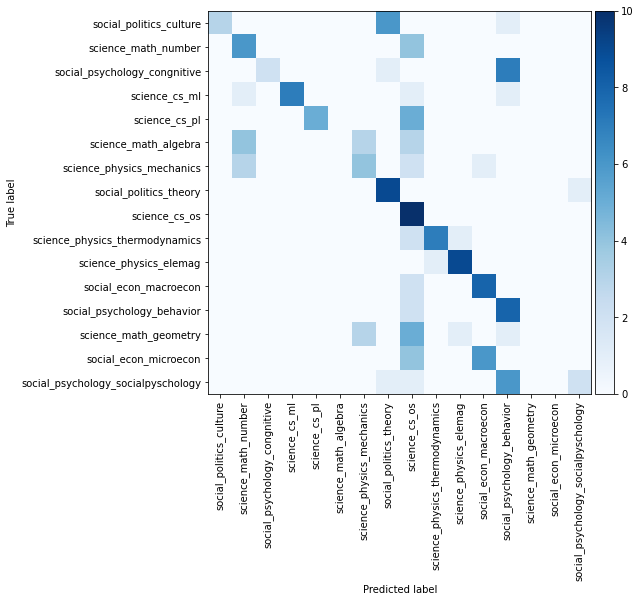

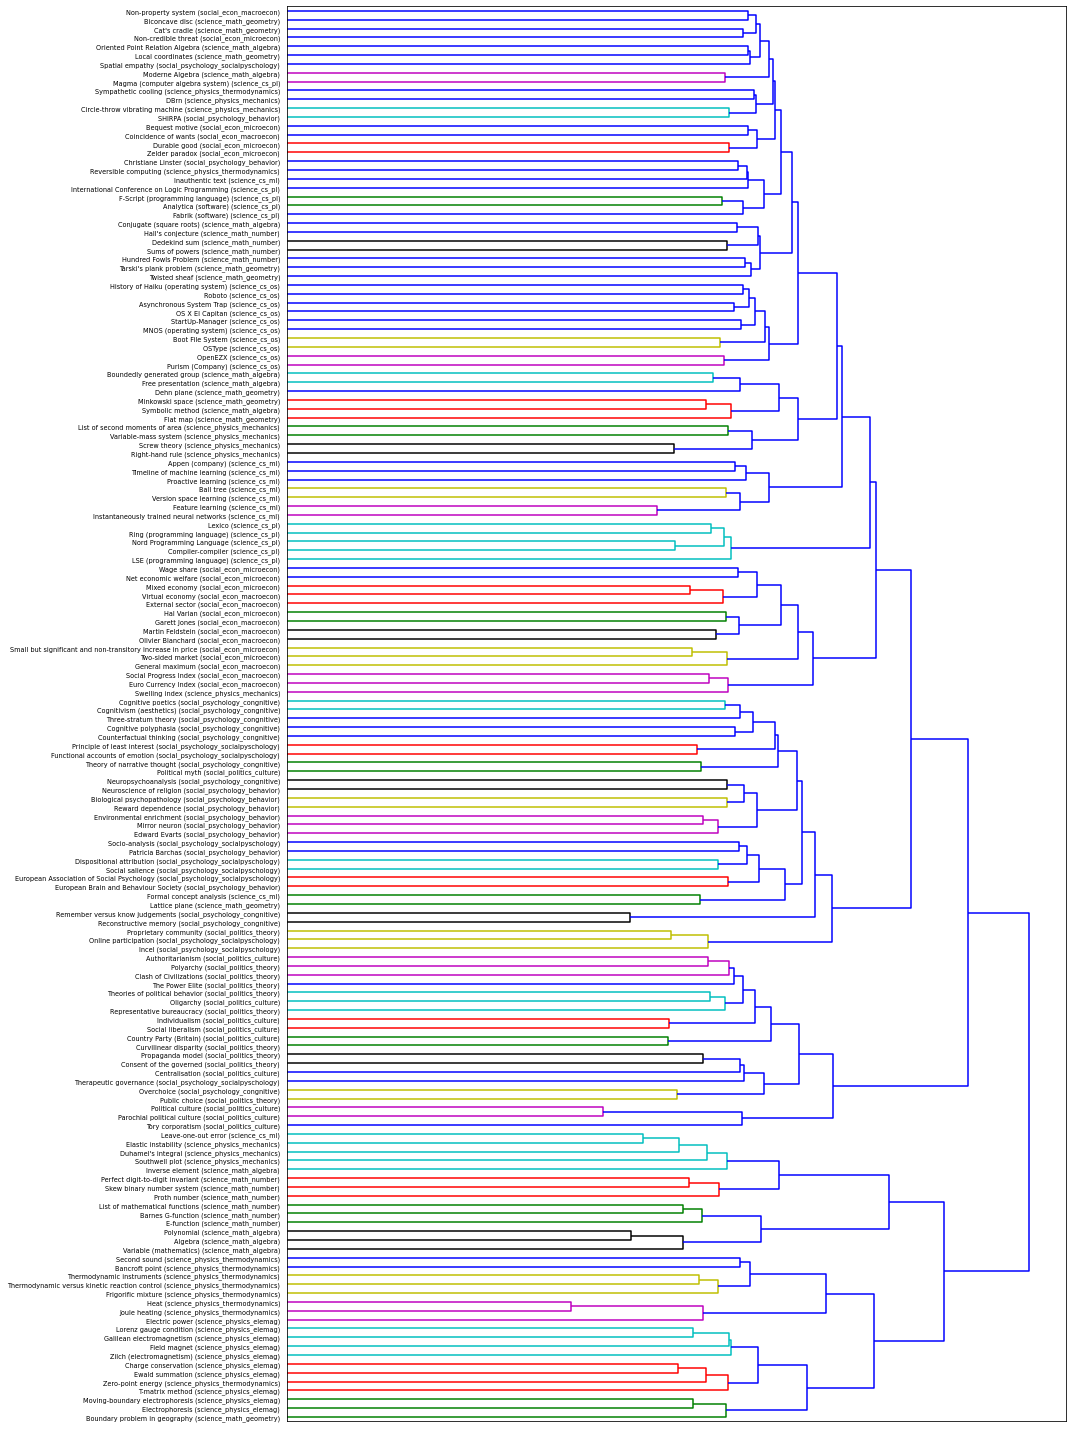

In [32]:
np.random.seed(1)
feature_path = "./data/Wiki/tfidf/tfidf.npy"
label_path = "./data/Wiki/tfidf/label.csv"

print("Feature path is: %s" % feature_path)

"""
1. Pre-define number of clusters (some hints for part of 3.4 :)
n_level = 1, 2 clusters: {'social', 'science'}
n_level = 2, 6 clusters: {'social_politics', 'science_math',..., 'social_econ'}
n_level = 3, 16 clusters: {'social_politics_culture', 'science_math_number',... 
                           'social_psychology_socialpyschology'}
"""
n_level = 3
labels, titles, cats = utils.get_label(label_path, n_level)
print("Categories: {}".format(cats))

"""
2. Hierarchical clustering
"""
fs = np.load(feature_path, allow_pickle=True)[()]
linkage_matrix, pred = hierarchical_cluster(
    fs.toarray(), n_clusters=len(cats), method='ward', metric='cosine'
)
_, cm, purity = get_purity(pred, labels)
nmi = get_nmi(pred, labels)
plot_confusion_matrix(
    cm, cats, normalize=False, rotation=90, figsize=(3*n_level, 3*n_level)
)
print("Ward, NMI: %.3f, Purity: %.3f" % (nmi, purity))
plot_dendrogram(
    linkage_matrix, titles, orientation='right', figsize=(15, 20), rotation=0
)


Using K-means!
K-means, NMI: 0.514, Purity: 0.425


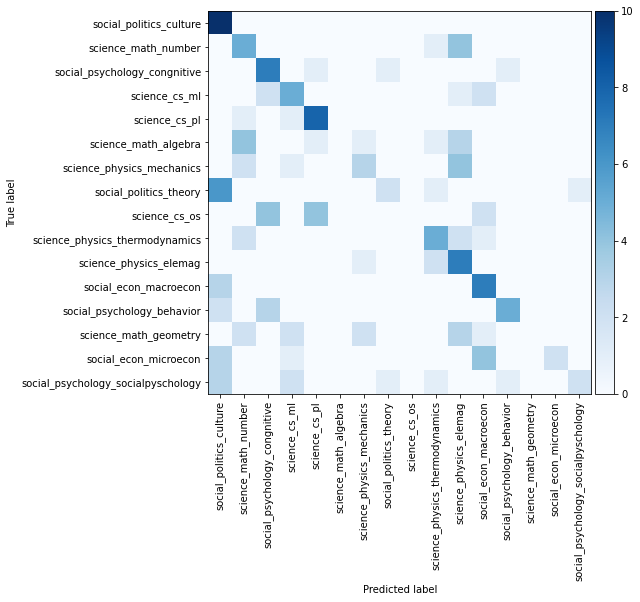

In [ ]:
"""
3. Flat clustering
"""
pred = kmeans_cluster(fs, len(cats), n_rounds=5, maxrun=300)
_, cm, purity = get_purity(pred, labels)
nmi = get_nmi(pred, labels)
plot_confusion_matrix(
    cm, cats, normalize=False, rotation=90, figsize=(3*n_level, 3*n_level)
)
print("K-means, NMI: %.3f, Purity: %.3f" % (nmi, purity))
plt.show()

Using spectral clustering!
Spectral Cluster, NMI: 0.689, Purity: 0.581


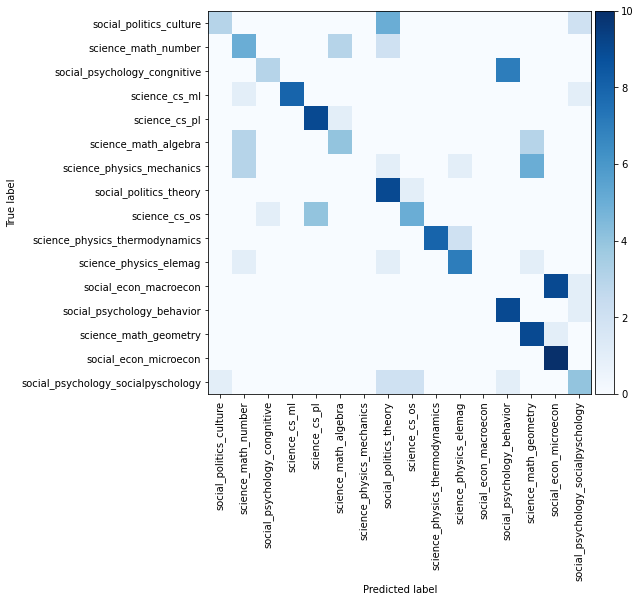

In [16]:
"""
4. my_cluster
"""
pred = my_cluster(fs, len(cats),len(cats),20,10,"discretize")  
_, cm, purity = get_purity(pred, labels)
nmi = get_nmi(pred, labels)
plot_confusion_matrix(
    cm, cats, normalize=False, rotation=90, figsize=(3*n_level, 3*n_level)
)
print("Spectral Cluster, NMI: %.3f, Purity: %.3f" % (nmi, purity))
plt.show()

**Tuning hyperparameters of k-mean clustering**

In [ ]:
rounds = [5,10,20,50]
print("Maxrun is still.")
for r in rounds:
  print("n_rounds = ", r)
  pred = kmeans_cluster(fs, len(cats), n_rounds=r, maxrun=300)
  _, cm, purity = get_purity(pred, labels)
  nmi = get_nmi(pred, labels)
  print("K-means, NMI: %.3f, Purity: %.3f" % (nmi, purity))

maxruns = [100,300,500,1000]
print("n_rounds is still.")
for m in maxruns:
  print("maxrun = ", m)
  pred = kmeans_cluster(fs, len(cats), n_rounds=20, maxrun=m)
  _, cm, purity = get_purity(pred, labels)
  nmi = get_nmi(pred, labels)
  print("K-means, NMI: %.3f, Purity: %.3f" % (nmi, purity))


Maxrun is still.
n_rounds =  5
Using K-means!
K-means, NMI: 0.584, Purity: 0.481
n_rounds =  10
Using K-means!
K-means, NMI: 0.555, Purity: 0.463
n_rounds =  20
Using K-means!
K-means, NMI: 0.609, Purity: 0.506
n_rounds =  50
Using K-means!
K-means, NMI: 0.618, Purity: 0.544
n_rounds is still.
maxrun =  100
Using K-means!
K-means, NMI: 0.549, Purity: 0.450
maxrun =  300
Using K-means!
K-means, NMI: 0.574, Purity: 0.463
maxrun =  500
Using K-means!
K-means, NMI: 0.583, Purity: 0.475
maxrun =  1000
Using K-means!
K-means, NMI: 0.612, Purity: 0.550


**Tuning hyperparameters of hierarchical clustering**

In [ ]:
methods = ["single","complete","average","weighted","centroid","median","ward"]
for m in methods:
  print("method is", m)
  linkage_matrix, pred = hierarchical_cluster(
      fs.toarray(), n_clusters=len(cats), method=m, metric='cosine'
  )
  _, cm, purity = get_purity(pred, labels)
  nmi = get_nmi(pred, labels)

  print("Ward, NMI: %.3f, Purity: %.3f" % (nmi, purity))


method is single
Using hierarchical clustering!
Ward, NMI: 0.171, Purity: 0.163
method is complete
Using hierarchical clustering!
Ward, NMI: 0.647, Purity: 0.556
method is average
Using hierarchical clustering!
Ward, NMI: 0.575, Purity: 0.362
method is weighted
Using hierarchical clustering!
Ward, NMI: 0.653, Purity: 0.450
method is centroid
Using hierarchical clustering!
Ward, NMI: 0.163, Purity: 0.156
method is median
Using hierarchical clustering!
Ward, NMI: 0.160, Purity: 0.156
method is ward
Using hierarchical clustering!
Ward, NMI: 0.608, Purity: 0.500


Tuning hyperparameters of my clustering (Spectral Clustering)

In [ ]:
n_components = [2,5,10,16]  #Change of number of eigenvectors
for n in n_components:
  print("Component number is", n)
  pred = my_cluster(fs, len(cats),n,20,10,"kmeans")
  _, cm, purity = get_purity(pred, labels)
  nmi = get_nmi(pred, labels)
  print("Spectral Cluster, NMI: %.3f, Purity: %.3f" % (nmi, purity))

n_init = [5,10,20,50]
for n in n_init:
  print("Number of time the k-means algorithm will be run is", n)
  pred = my_cluster(fs, len(cats),len(cats),n,10,"kmeans")
  _, cm, purity = get_purity(pred, labels)
  nmi = get_nmi(pred, labels)
  print("Spectral Cluster, NMI: %.3f, Purity: %.3f" % (nmi, purity))

n_neighbors = [5,10,20,50]
for n in n_neighbors:
  print("Number of neighbors to use is", n)
  pred = my_cluster(fs, len(cats),len(cats),20,n,"kmeans")
  _, cm, purity = get_purity(pred, labels)
  nmi = get_nmi(pred, labels)
  print("Spectral Cluster, NMI: %.3f, Purity: %.3f" % (nmi, purity))

print("Use Discretization to assign labels after the laplacian embedding")
pred = my_cluster(fs, len(cats),len(cats),20,10,"discretize")   # Use Discretization to assign labels after the laplacian embedding
_, cm, purity = get_purity(pred, labels)
nmi = get_nmi(pred, labels)
print("Spectral Cluster, NMI: %.3f, Purity: %.3f" % (nmi, purity))

Component number is 2
Using spectral clustering!
Spectral Cluster, NMI: 0.478, Purity: 0.362
Component number is 5
Using spectral clustering!
Spectral Cluster, NMI: 0.542, Purity: 0.406
Component number is 10
Using spectral clustering!
Spectral Cluster, NMI: 0.592, Purity: 0.475
Component number is 16
Using spectral clustering!
Spectral Cluster, NMI: 0.538, Purity: 0.475
Number of time the k-means algorithm will be run is 5
Using spectral clustering!
Spectral Cluster, NMI: 0.570, Purity: 0.494
Number of time the k-means algorithm will be run is 10
Using spectral clustering!
Spectral Cluster, NMI: 0.599, Purity: 0.494
Number of time the k-means algorithm will be run is 20
Using spectral clustering!
Spectral Cluster, NMI: 0.538, Purity: 0.475
Number of time the k-means algorithm will be run is 50
Using spectral clustering!
Spectral Cluster, NMI: 0.596, Purity: 0.500
Number of neighbors to use is 5
Using spectral clustering!
Spectral Cluster, NMI: 0.538, Purity: 0.475
Number of neighbors 

By tuning hyperparameters in k-mean, hierarchical cluster, and my cluster(spectral cluster), I can see that spectral cluster returns the best result. From the confusion matrix, we can see that there are more dark blue blocks on the matrix of spectral cluster, hierarchical cluster ranks the second, and k-mean performs the worst.

In k-mean, it does good on social_science_culture, science_cs_pl, science_physics_elemag, social_econ_macroecon. But it does bad on cience_math_algebra, science_cs_os, science_math_geometry and many other blocks which is light blues.

In hierarchical cluster, it does good on social_politics_theory, science_cs_os,science_physics_elemag, social_econ_macroecon, social_psychology_behavior. But it does bad on science_math_algebra, science_math_geometry, and social_econ_microecon.

In spectral cluster, it does good on a lot subjects, but only does bad on science_physics_mechanics and social_econ_macroecon. 

It can be seen that spectral cluster performs the best.

In hierarchical cluster tree, the first level combines two subjects together because they are the closest. The second level combines two clusters from level 1 if they are the closest. Such step repeats until the total cluster number reaches 16.

There is an example helps show the algorithm. In the tree, there are a lot "science_cs_os" classes are in the same cluster. They clust first two by two, and then four by four until there is no more clusters.

In [33]:
clusters = [2,6,16]
for c in clusters:
  print("clusters = ", c)
  pred = kmeans_cluster(fs, c, n_rounds=10, maxrun=500)
  _, cm, purity = get_purity(pred, labels)
  nmi = get_nmi(pred, labels)
  print("K-means, NMI: %.3f, Purity: %.3f" % (nmi, purity))

clusters =  2
Using K-means!
K-means, NMI: 0.184, Purity: 0.125
clusters =  6
Using K-means!
K-means, NMI: 0.422, Purity: 0.300
clusters =  16
Using K-means!
K-means, NMI: 0.591, Purity: 0.487


In [ ]:
clusters = [2,6,16]
for c in clusters:
  print("clusters = ", c)
  linkage_matrix, pred = hierarchical_cluster(
      fs.toarray(), n_clusters=c, method='ward', metric='cosine'
  )
  _, cm, purity = get_purity(pred, labels)
  nmi = get_nmi(pred, labels)

  print("Ward, NMI: %.3f, Purity: %.3f" % (nmi, purity))

clusters =  2
Using hierarchical clustering!
Ward, NMI: 0.192, Purity: 0.125
clusters =  6
Using hierarchical clustering!
Ward, NMI: 0.493, Purity: 0.275
clusters =  16
Using hierarchical clustering!
Ward, NMI: 0.608, Purity: 0.500


When $k=2$, both methods perform not good. But when $k$ is increasing, hierachical cluster perform better than k-mean cluster.

$k=2$ means we devide all the subjects into social and science.

$k=6$ means we divide all the subjects into social_politics, science_math',..., social_econ.

$k=16$ means we divide all the subjects into social_politics_culture, science_math_number,...,social_psychology_socialpyschology.